In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import optuna
import warnings
import sys

# ---------------------------------------------------------
# 0. Global Settings
# ---------------------------------------------------------
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("notebook", font_scale=1.1)

FIXED_TARGET_VOL = 0.25  # 타협 불가한 타겟 변동성

# ---------------------------------------------------------
# 1. Strategy Class (Optimized Structure)
# ---------------------------------------------------------
class MLVolTargetStrategy:
    def __init__(self, df_raw, params=None, verbose=False):
        """
        :param df_raw: pd.DataFrame (이미 로드된 데이터)
        :param params: dict (최적화된 파라미터)
        """
        self.df = df_raw.copy()
        self.verbose = verbose
        self.results = None
        self.feature_importances = None
        
        # Default Params (만약 params가 없을 경우 대비)
        self.params = params if params else {
            'n_estimators': 200, 'max_depth': 5, 'min_samples_leaf': 20,
            'target_vol': 0.25, # FIXED_TARGET_VOL
            'safe_vol': 0.08,
            'vol_window': 20, 'sma_window': 200, 'rsi_window': 14
        }
        
        # Unpack
        self.target_vol = self.params['target_vol']
        self.safe_vol = self.params['safe_vol']
        
        # RF Model
        self.rf_params = {
            'n_estimators': self.params['n_estimators'],
            'max_depth': self.params['max_depth'],
            'min_samples_leaf': self.params['min_samples_leaf'],
            'random_state': 42,
            'n_jobs': -1
        }

    def prepare_features(self):
        p = self.params
        
        # 1. Dynamic SMA
        sma_col = f"SMA_{p['sma_window']}"
        self.df[sma_col] = self.df['Close'].rolling(p['sma_window']).mean()
        self.df['Dist_SMA'] = (self.df['Close'] - self.df[sma_col]) / self.df[sma_col]
        
        # 2. Dynamic Volatility
        self.df['Vol_Dynamic'] = self.df['Close'].pct_change().rolling(p['vol_window']).std() * np.sqrt(252)
        
        # 3. Dynamic RSI
        def calc_rsi(series, period):
            delta = series.diff()
            gain = (delta.where(delta > 0, 0)).rolling(period).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
            rs = gain / (loss + 1e-9)
            return 100 - (100 / (1 + rs))
        self.df['RSI'] = calc_rsi(self.df['Close'], p['rsi_window'])

        # 4. Macro (Fixed Logic)
        macro_candidates = ['US_10Y_Yield', 'Volatility_VIX', 'Junk_Bonds', 'Japan_Nikkei']
        macro_feats = []
        for col in macro_candidates:
            if col in self.df.columns:
                if 'VIX' in col or 'Yield' in col:
                    self.df[f'{col}_Chg'] = self.df[col].pct_change(5)
                    macro_feats.append(f'{col}_Chg')
                else:
                    self.df[f'{col}_Trend'] = self.df[col].rolling(5).mean()
                    macro_feats.append(f'{col}_Trend')

        self.feature_cols = ['Dist_SMA', 'Vol_Dynamic', 'RSI'] + macro_feats
        
        # Lagging
        for col in self.feature_cols:
            self.df[col] = self.df[col].shift(1)

        # Target (Direction)
        self.df['Next_Ret'] = self.df['Close'].pct_change().shift(-1)
        self.df['Target_Lev'] = np.where(self.df['Next_Ret'] > 0, 2.0, 0.0)
        
        self.df.dropna(inplace=True)

    def run_backtest(self):
        unique_years = sorted(self.df.index.year.unique())
        start_idx = 3
        
        if len(unique_years) <= start_idx:
            return -999, 999 

        results_list = []
        model = RandomForestRegressor(**self.rf_params)
        importances_list = []

        if self.verbose:
            print(f"   > Strategy Running... (Target Vol: {self.target_vol})")

        for test_year in unique_years[start_idx:]:
            train_data = self.df[self.df.index.year < test_year]
            test_data = self.df[self.df.index.year == test_year]
            
            if len(test_data) == 0: continue
            
            # Fit & Predict
            model.fit(train_data[self.feature_cols], train_data['Target_Lev'])
            if self.verbose: importances_list.append(model.feature_importances_)
            
            ml_signal = model.predict(test_data[self.feature_cols])
            
            # Apply Logic
            final_levs = self._apply_strategy_logic(test_data, ml_signal)
            
            daily_ret = test_data['Next_Ret'].values
            
            daily_drag = 0.01 / 252 * (final_levs / 1.0).clip(0)
            strategy_ret = (final_levs * daily_ret) - daily_drag
            
            chunk = pd.DataFrame({
                'Market_Ret': daily_ret,
                'Strategy_Ret': strategy_ret,
                'Leverage': final_levs
            }, index=test_data.index)
            results_list.append(chunk)

        if not results_list:
            return -999, 999

        self.results = pd.concat(results_list)
        if self.verbose and importances_list:
            self.feature_importances = pd.Series(np.mean(importances_list, axis=0), index=self.feature_cols).sort_values(ascending=False)
            
        self._calculate_cumulative()
        
        # --- NEW: Calculate Custom Metric ---
        custom_score, vol_ratio = self._calc_custom_metric()
        
        return custom_score, vol_ratio

    def _calc_custom_metric(self):
        """
        [수정됨] Volatility-Adjusted Sharpe Ratio
        ★ 핵심 변경: Vol Ratio가 1.2를 넘으면 수학적 페널티 계산을 건너뛰고 즉시 탈락(Hard Fail) 처리함.
        """
        # 1. 데이터 준비
        # 데이터셋에 무위험이자율(Risk Free Rate) 컬럼이 없으므로 0.0으로 가정
        rf_rate = 0.0 
        position = self.results['Leverage']
        forward_returns = self.results['Market_Ret']
        
        # 데이터가 없으면 즉시 종료
        if len(position) == 0: 
            return -999.0, 999.0
        
        # 2. 전략 수익률 구성 (공식: rf * (1-pos) + pos * ret)
        strategy_returns = rf_rate * (1 - position) + position * forward_returns
        
        # 3. 표준편차 및 Vol Ratio 계산 (Fail Fast를 위해 먼저 계산)
        strategy_std = strategy_returns.std()
        market_std = forward_returns.std()
        
        # 시장 변동성이 0이면 계산 불가
        if market_std == 0: 
            return -999.0, 999.0
            
        vol_ratio = strategy_std / market_std

        if vol_ratio > 1.2:
            return -10.0, vol_ratio  # -10점 부여 (Sharpe가 보통 1~2이므로 -10은 절대 선택 안 됨)

        # ---------------------------------------------------------
        # 4. Sharpe Ratio 계산 (Geometric Mean 방식 적용)
        # ---------------------------------------------------------
        trading_days_per_yr = 252
        
        if strategy_std == 0:
            return -999.0, 0.0

        # Strategy Geometric Mean Excess Return
        strategy_excess_returns = strategy_returns - rf_rate
        # (1+r)의 누적곱을 통해 기하평균 산출
        strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
        strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(position)) - 1
        
        sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
        
        # ---------------------------------------------------------
        # 5. 페널티 적용 (Return Penalty Only)
        # ---------------------------------------------------------
        # Vol Penalty: 위에서 이미 1.2 초과 시 탈락시켰으므로, 여기 도달했다는 것은
        # Vol Ratio <= 1.2라는 뜻임. 따라서 Vol Penalty는 항상 1.0(감점 없음)이 됨.
        vol_penalty = 1.0 
        
        # Return Penalty: 시장 수익률보다 못 벌었을 경우 페널티
        market_excess_returns = forward_returns - rf_rate
        market_excess_cumulative = (1 + market_excess_returns).prod()
        market_mean_excess_return = (market_excess_cumulative) ** (1 / len(position)) - 1
        
        return_gap = max(
            0,
            (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr,
        )
        return_penalty = 1 + (return_gap**2) / 100
        
        # 최종 점수 산출
        adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
        
        # 상한선 (1,000,000) 캡 적용
        return min(float(adjusted_sharpe), 1_000_000), vol_ratio

    def _apply_strategy_logic(self, data, ml_signal):
        price = data['Close'].values
        sma = data[f"SMA_{self.params['sma_window']}"].values
        vol = data['Vol_Dynamic'].values
        
        final_levs = []
        for p, s, v, sig in zip(price, sma, vol, ml_signal):
            if p < s:
                lev = 0.0
            else:
                curr_safe_vol = max(v, self.safe_vol)
                scalar = self.target_vol / curr_safe_vol
                lev = min(sig * scalar, 2.0)
            final_levs.append(lev)
        return np.array(final_levs)

    def _calculate_cumulative(self):
        self.results['Cum_Mkt'] = (1 + self.results['Market_Ret']).cumprod()
        self.results['Cum_Str'] = (1 + self.results['Strategy_Ret']).cumprod()
        self.results['Drawdown'] = (self.results['Cum_Str'] / self.results['Cum_Str'].cummax()) - 1

    def print_report(self):
        print("\n" + "="*60)
        print("📊 FINAL OPTIMIZED REPORT")
        print("="*60)
        res = self.results
        metrics = {}
        for col in ['Market_Ret', 'Strategy_Ret']:
            name = 'Benchmark' if col == 'Market_Ret' else 'Strategy'
            ret = res[col]
            tot = (np.prod(1 + ret) - 1) * 100
            vol = ret.std() * np.sqrt(252) * 100
            sh = (ret.mean() / ret.std()) * np.sqrt(252) if ret.std() > 0 else 0
            dd = ((1+ret).cumprod() / (1+ret).cumprod().cummax() - 1).min() * 100
            metrics[name] = [tot, vol, sh, dd]
            
        df_met = pd.DataFrame(metrics, index=['Return(%)', 'Vol(%)', 'Sharpe', 'MDD(%)']).T
        print(df_met.round(2))
        
        vol_ratio = df_met.loc['Strategy', 'Vol(%)'] / df_met.loc['Benchmark', 'Vol(%)']
        print("-" * 60)
        print(f"Risk Check (Vol Ratio <= 1.2): {vol_ratio:.2f}x -> {'✅ PASS' if vol_ratio <= 1.2 else '❌ FAIL'}")
        print("-" * 60)

    def plot_results(self):
        # 4개의 서브플롯 생성 (Equity, Drawdown, Leverage, Yearly Returns)
        fig = plt.figure(figsize=(14, 16))
        gs = fig.add_gridspec(4, 1, height_ratios=[2, 1, 1, 1.2])
        
        # 1. Equity
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(self.results.index, self.results['Cum_Mkt'], color='gray', alpha=0.5, label='Benchmark')
        ax1.plot(self.results.index, self.results['Cum_Str'], color='#DC143C', linewidth=2, label='Strategy')
        ax1.set_yscale('log')
        ax1.set_title(f'Optimized Equity Curve (Target Vol: {self.target_vol})')
        ax1.legend()
        ax1.grid(True, which='both', alpha=0.3)
        
        # 2. Drawdown
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        ax2.fill_between(self.results.index, self.results['Drawdown'], 0, color='red', alpha=0.3)
        ax2.set_title('Drawdown')
        ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        
        # 3. Leverage
        ax3 = fig.add_subplot(gs[2], sharex=ax1)
        ax3.plot(self.results.index, self.results['Leverage'], color='purple', linewidth=1)
        ax3.set_title('Leverage')
        ax3.set_ylim(-0.1, 2.2)

        # 4. Yearly Return Comparison (★ 복구된 차트)
        ax4 = fig.add_subplot(gs[3])
        yearly_res = self.results.resample('Y').apply(lambda x: (np.prod(1+x) - 1)*100)
        years = yearly_res.index.year
        x = np.arange(len(years))
        width = 0.35
        
        rects1 = ax4.bar(x - width/2, yearly_res['Market_Ret'], width, label='Benchmark', color='gray', alpha=0.7)
        rects2 = ax4.bar(x + width/2, yearly_res['Strategy_Ret'], width, label='Strategy', color='#DC143C')
        
        ax4.set_title('Yearly Return Comparison', fontsize=12)
        ax4.set_xticks(x)
        ax4.set_xticklabels(years)
        ax4.legend()
        ax4.grid(axis='y', alpha=0.3)
        
        # 바 위에 숫자 표시
        ax4.bar_label(rects1, fmt='%.0f', padding=3, fontsize=9)
        ax4.bar_label(rects2, fmt='%.0f', padding=3, fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        plt.show()

# ---------------------------------------------------------
# 2. Objective Function (Target Vol Fixed)
# ---------------------------------------------------------
def objective(trial, df_raw):
    # Search Space Define
    params = {
        # A. ML Params
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 20, 100, step=10),
        
        # B. Strategy Params
        'target_vol': FIXED_TARGET_VOL,  # Still Fixed
        'safe_vol': trial.suggest_float('safe_vol', 0.05, 0.15),
        
        # C. Feature Params
        'vol_window': trial.suggest_int('vol_window', 10, 60, step=5),
        'sma_window': trial.suggest_int('sma_window', 100, 250, step=10),
        'rsi_window': trial.suggest_int('rsi_window', 10, 25)
    }
    
    try:
        strategy = MLVolTargetStrategy(df_raw, params=params)
        strategy.prepare_features()
        
        # Returns (Adjusted_Sharpe, Vol_Ratio)
        adjusted_score, vol_ratio = strategy.run_backtest()
        
        # NOTE: The manual hard constraint "if vol_ratio > 1.2: return -10" is REMOVED.
        # The Custom Metric now mathematically penalizes high volatility 
        # via the 'vol_penalty' divisor.
        
        return adjusted_score
        
    except Exception as e:
        # Penalize failures heavily
        return -10.0


# ---------------------------------------------------------
# [Add-on] 분석용 클래스 (새로운 구조 호환 패치)
# ---------------------------------------------------------
import shap
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

class FeatureAnalyzer(MLVolTargetStrategy):
    """
    새로운 MLVolTargetStrategy 구조(df_raw, params)에 맞춘 분석 클래스
    """
    def run_shap_analysis(self):
        print("\n" + "="*60)
        print("🔍 SHAP & SHARPE IMPACT ANALYSIS")
        print("="*60)

        # 1. 전체 데이터로 모델 재학습
        X = self.df[self.feature_cols]
        y = self.df['Target_Lev']
        returns = self.df['Next_Ret']

        model = RandomForestRegressor(**self.rf_params)
        model.fit(X, y)
        print("✅ Analysis Model Trained on Full Data")

        # -------------------------------------------------------
        # A. SHAP Analysis
        # -------------------------------------------------------
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)
        
        print("\n[1] SHAP Summary Plot...")
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X, plot_type="bar", show=False)
        plt.title("SHAP Feature Importance (Mean |SHAP|)", fontsize=15)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X, show=False)
        plt.title("SHAP Beeswarm Plot (Direction Impact)", fontsize=15)
        plt.tight_layout()
        plt.show()

        # -------------------------------------------------------
        # B. Sharpe Impact (Permutation)
        # -------------------------------------------------------
        print("\n[2] Calculating Feature Impact on Sharpe Ratio...")
        
        base_preds = model.predict(X)
        base_strategy_ret = base_preds * returns 
        base_sharpe = self._calc_sharpe(base_strategy_ret)
        
        print(f"   > Baseline Raw Sharpe: {base_sharpe:.4f}")

        importances = {}
        
        for col in self.feature_cols:
            X_shuffled = X.copy()
            X_shuffled[col] = np.random.permutation(X[col].values)
            
            shuffled_preds = model.predict(X_shuffled)
            shuffled_ret = shuffled_preds * returns
            shuffled_sharpe = self._calc_sharpe(shuffled_ret)
            
            drop_in_sharpe = base_sharpe - shuffled_sharpe
            importances[col] = drop_in_sharpe
            
        df_imp = pd.DataFrame(list(importances.items()), columns=['Feature', 'Sharpe_Drop'])
        df_imp.sort_values(by='Sharpe_Drop', ascending=True, inplace=True)

        plt.figure(figsize=(12, 8))
        colors = ['red' if x < 0 else 'royalblue' for x in df_imp['Sharpe_Drop']]
        plt.barh(df_imp['Feature'], df_imp['Sharpe_Drop'], color=colors)
        plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
        plt.title(f"Feature Impact on Sharpe Ratio\n(Baseline Sharpe: {base_sharpe:.2f})", fontsize=15)
        plt.xlabel("Drop in Sharpe Ratio (Higher is Better Feature)")
        plt.grid(axis='x', alpha=0.3)
        
        for index, value in enumerate(df_imp['Sharpe_Drop']):
            plt.text(value, index, f' {value:.3f}', va='center', fontsize=10)
            
        plt.tight_layout()
        plt.show()

    def _calc_sharpe(self, returns_series):
        if returns_series.std() == 0: return 0
        return (returns_series.mean() / returns_series.std()) * np.sqrt(252)


class ModelVerifier(MLVolTargetStrategy):
    """
    새로운 MLVolTargetStrategy 구조에 맞춘 PDP 검증 클래스
    """
    def run_pdp_analysis(self):
        print("\n" + "="*60)
        print("🕵️ PDP ANALYSIS: 검증의 시간")
        print("="*60)
        
        X = self.df[self.feature_cols]
        y = self.df['Target_Lev']
        model = RandomForestRegressor(**self.rf_params)
        model.fit(X, y)
        
        # Helper: case-insensitive finder for feature aliases
        def find_feature(keyword, exclude=None):
            keyword = keyword.lower()
            exclude = tuple(exclude or ())
            for col in self.feature_cols:
                name = col.lower()
                if keyword in name and not any(ex in name for ex in exclude):
                    return col
            return None

        # 1. 변동성 피처 찾기 (Vol_Dynamic 혹은 Vol_XX)
        vol_feat = find_feature('vol', exclude=('vix',))
        # 2. 이격도 피처 찾기 (Dist_SMA)
        sma_feat = find_feature('dist_sma')
        # 3. VIX 파생 피처 (존재할 경우)
        vix_feat = find_feature('vix')
        yield_feat = find_feature('us_10y')
        junk_feat = find_feature('junk')
        nikkei_feat = find_feature('nikkei')

        candidate_features = [
            vol_feat,
            'RSI' if 'RSI' in self.feature_cols else None,
            sma_feat,
            yield_feat,
            vix_feat,
        ]

        # dataset_crawler.py에서 정의된 정확한 피처명 우선 고려
        dataset_aliases = {
            'junk_bonds_trend': ['Junk_Bonds_Trend', 'junk_bonds_trend'],
            'japan_nikkei_trend': ['Japan_Nikkei_Trend', 'japan_nikkei_trend'],
        }
        for alias_list in dataset_aliases.values():
            match = next((name for name in alias_list if name in self.feature_cols), None)
            if match and match not in candidate_features:
                candidate_features.append(match)

        candidate_features.extend([junk_feat, nikkei_feat])

        # 해당 피처가 실제로 있는지 확인 (없으면 제외)
        final_features = []
        for feat in candidate_features:
            if feat and feat in self.feature_cols and feat not in final_features:
                final_features.append(feat)
        if not final_features:
            print("⚠️ PDP를 그릴 피처를 찾을 수 없습니다.")
            return

        print(f"📊 Plotting PDP for: {final_features}")

        display = PartialDependenceDisplay.from_estimator(
            model,
            X,
            final_features,
            kind='average',
            n_cols=2
        )
        display.figure_.set_size_inches(14, 14)
        display.figure_.suptitle('Partial Dependence Plots', fontsize=20, y=1.02)
        display.figure_.tight_layout()
        plt.show()


c:\Users\User\miniconda3\envs\mlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📂 Loading Data... (nasdaq_new.csv)
✅ Loaded 4495 rows.

🚀 OPTIMIZATION START (Fixed Target Vol: 0.25)
   Constraint: Vol Ratio <= 1.2 (Strict)


Best trial: 16. Best value: 0.786163: 100%|██████████| 50/50 [02:19<00:00,  2.80s/it]



🏆 BEST PARAMETERS FOUND
  - n_estimators: 250
  - max_depth: 5
  - min_samples_leaf: 90
  - safe_vol: 0.12896516645216194
  - vol_window: 20
  - sma_window: 210
  - rsi_window: 14
  - target_vol: 0.25
  > Best Validation Sharpe: 0.7862

🔎 FINAL VERIFICATION RUN...
   > Strategy Running... (Target Vol: 0.25)

📊 FINAL OPTIMIZED REPORT
           Return(%)  Vol(%)  Sharpe  MDD(%)
Benchmark     769.50   20.61    0.81  -36.40
Strategy     1273.07   24.21    0.85  -32.71
------------------------------------------------------------
Risk Check (Vol Ratio <= 1.2): 1.17x -> ✅ PASS
------------------------------------------------------------


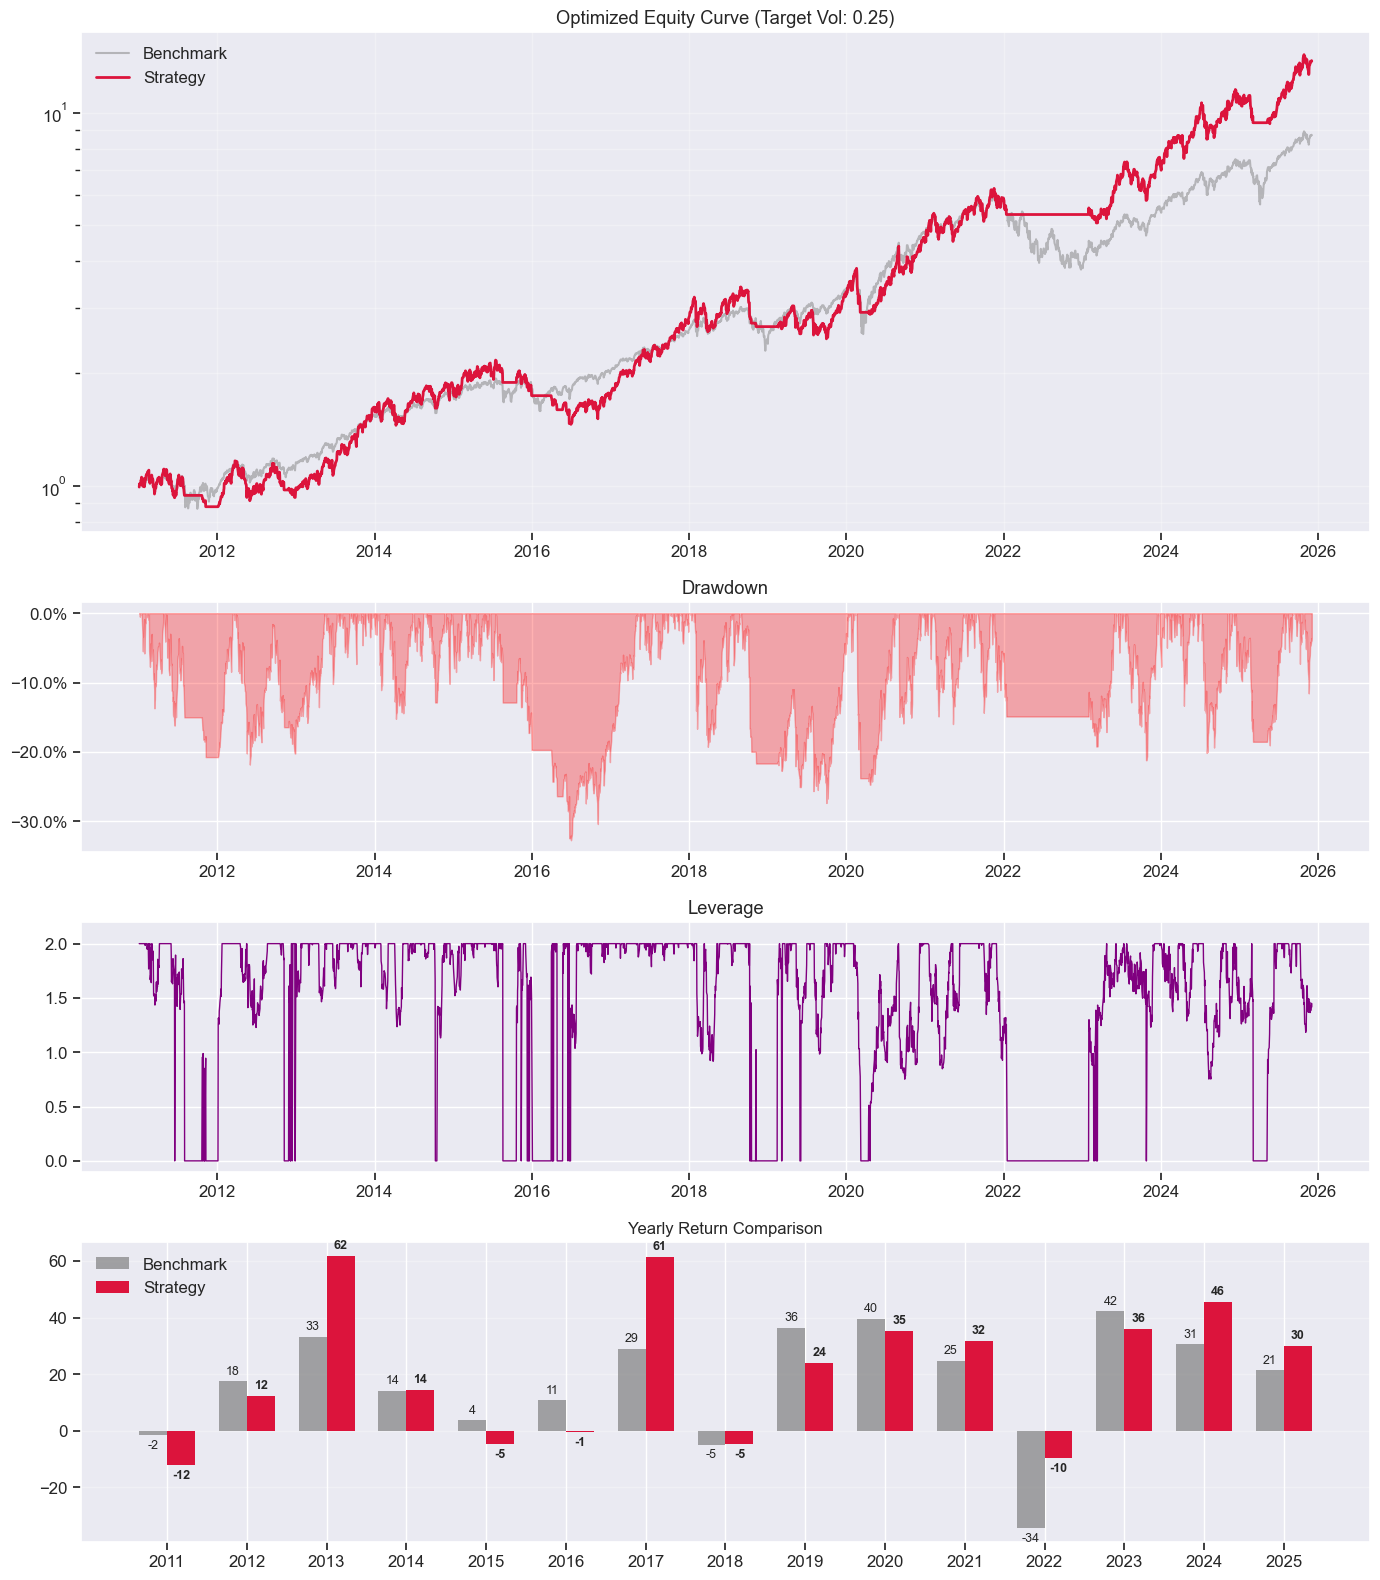

In [2]:
# ---------------------------------------------------------
# 3. Main Execution
# ---------------------------------------------------------

file_path = 'nasdaq_new.csv'

print(f"📂 Loading Data... ({file_path})")

# 데이터는 여기서 한 번만 로드하여 계속 재사용 (속도 향상)
df_raw = pd.read_csv(file_path, index_col=0, parse_dates=True)
print(f"✅ Loaded {len(df_raw)} rows.")

print("\n" + "="*60)
print(f"🚀 OPTIMIZATION START (Fixed Target Vol: {FIXED_TARGET_VOL})")
print("   Constraint: Vol Ratio <= 1.2 (Strict)")
print("="*60)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(lambda trial: objective(trial, df_raw), n_trials=50, show_progress_bar=True)

print("\n🏆 BEST PARAMETERS FOUND")
best_params = study.best_params

# Optuna는 optimize 함수 안에서 고정값(target_vol)을 저장하지 않으므로 수동 추가
best_params['target_vol'] = FIXED_TARGET_VOL 

for k, v in best_params.items():
    print(f"  - {k}: {v}")
print(f"  > Best Validation Sharpe: {study.best_value:.4f}")
    
# --- Final Verification ---
print("\n🔎 FINAL VERIFICATION RUN...")
final_strat = MLVolTargetStrategy(df_raw, params=best_params, verbose=True)
final_strat.prepare_features()
final_strat.run_backtest()
final_strat.print_report()
final_strat.plot_results()


✅ Loaded Data for Analysis: 4495 rows

🔍 SHAP & SHARPE IMPACT ANALYSIS
✅ Analysis Model Trained on Full Data

[1] SHAP Summary Plot...


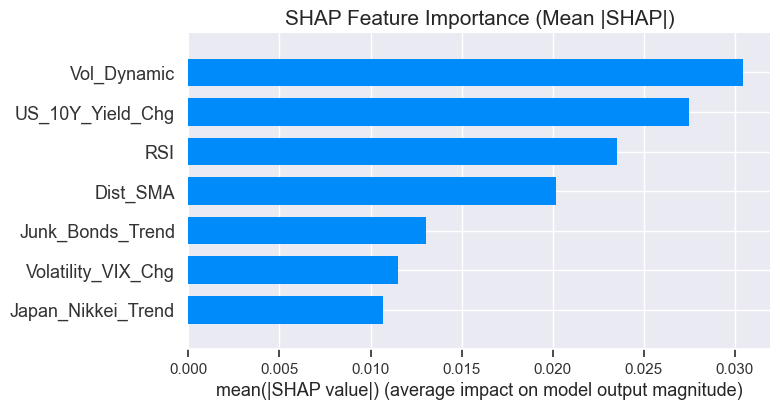

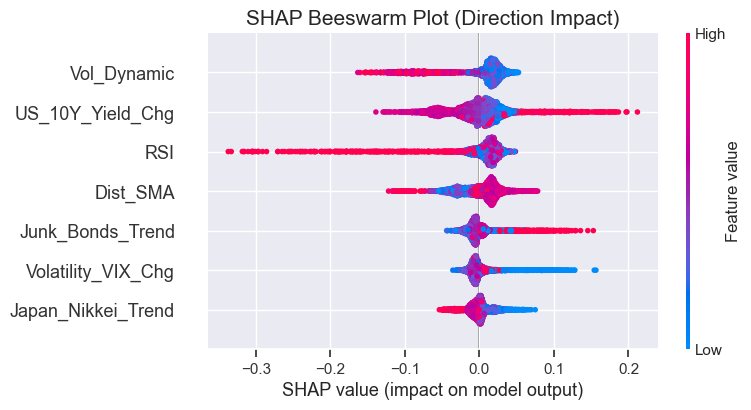


[2] Calculating Feature Impact on Sharpe Ratio...
   > Baseline Raw Sharpe: 1.1639


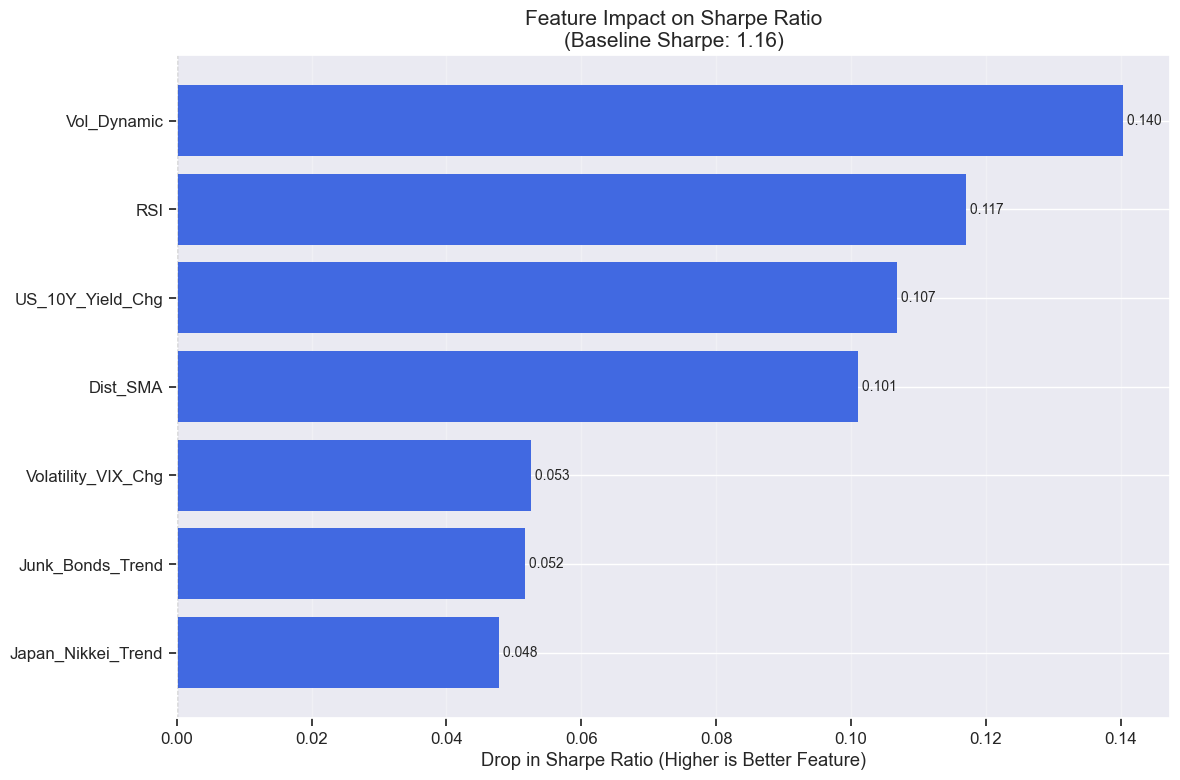


🕵️ PDP ANALYSIS: 검증의 시간
📊 Plotting PDP for: ['Vol_Dynamic', 'RSI', 'Dist_SMA', 'US_10Y_Yield_Chg', 'Volatility_VIX_Chg', 'Junk_Bonds_Trend', 'Japan_Nikkei_Trend']


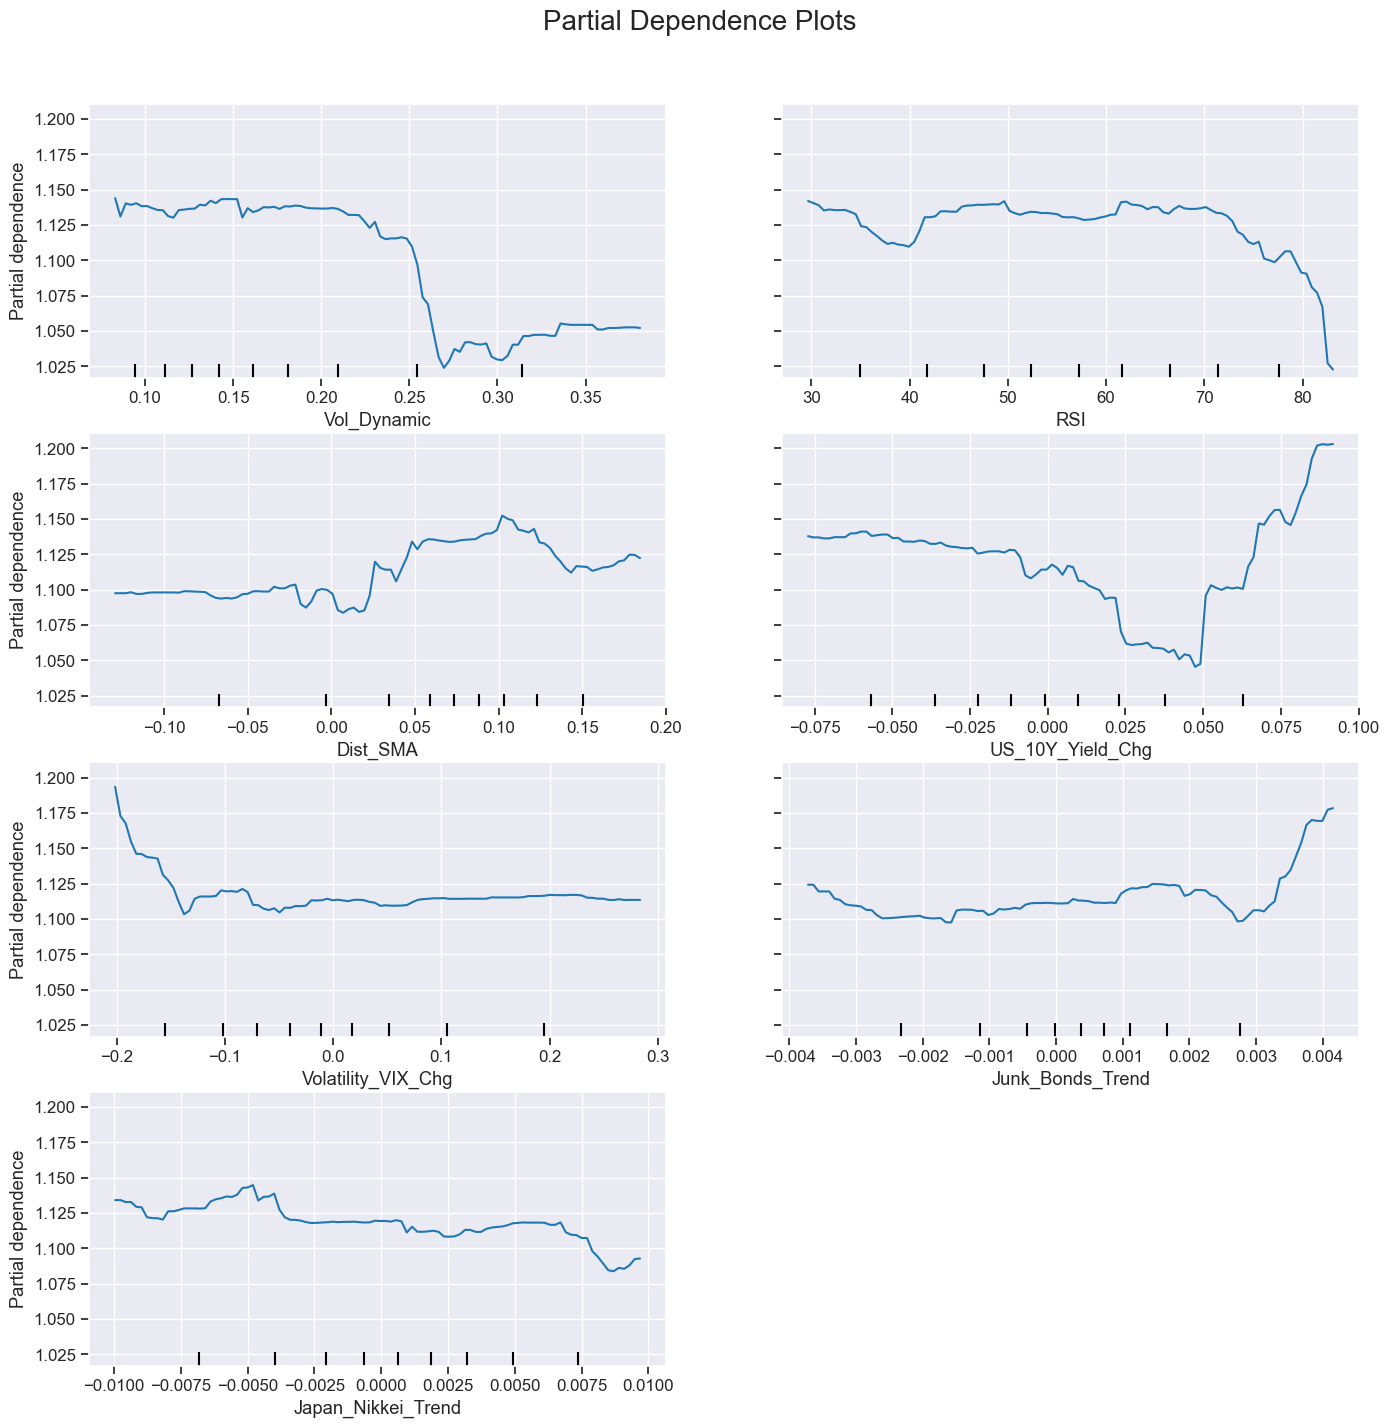

In [3]:
df_raw = pd.read_csv(file_path, index_col=0, parse_dates=True)
print(f"✅ Loaded Data for Analysis: {len(df_raw)} rows")

# 2. 파라미터 설정 (최적화된 값이 있다면 그것을 사용, 없다면 기본값)
# 여기서는 테스트를 위해 기본값에 Target Vol 0.25 고정
analysis_params = {
    'n_estimators': 200, 
    'max_depth': 5, 
    'min_samples_leaf': 20,
    'target_vol': 0.25,      # ★ FIXED
    'safe_vol': 0.08, 
    'vol_window': 20, 
    'sma_window': 200, 
    'rsi_window': 14
}

# 3. SHAP & Sharpe Impact 분석 실행
# (filepath가 아니라 df_raw와 params를 넣습니다)
analyzer = FeatureAnalyzer(df_raw, params=analysis_params)
analyzer.prepare_features() # 피처 생성 필수
analyzer.run_shap_analysis()

# 4. PDP 분석 실행
verifier = ModelVerifier(df_raw, params=analysis_params)
verifier.prepare_features() # 피처 생성 필수
verifier.run_pdp_analysis()